In [136]:
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pymc3 as pm
import matplotlib.ticker as tk
import re
import pickle
from scipy.stats import norm

In [137]:
!mkdir outputs/bayes_opt_gp_m52

out_dir = 'outputs/bayes_opt_gp_m52/'

mkdir: outputs/bayes_opt_gp_m52: File exists


In [138]:
root_dir = 'outputs/mml_gp_m52/'

Notes: 

We need to do this on smaller amounts of data or it won't be much use. 

First calculate the Expected improvement on all the data, then go back and create predictions using subsets of training data. 

# All data calculation

## Import data

This takes the predictions from the MML model calculated previously. 

In [139]:
pred = pd.read_csv(root_dir+'predictions.csv')
pred.head()

,f_pred,sd_f,sd_y,n_s,basis,n,lb,ub,n_log
0,1.791714,0.205638,0.205796,-0.060414,psi,10.0,1.380439,2.202989,2.302585
1,1.813292,0.035454,0.036361,0.099195,psi,20.0,1.742384,1.884201,2.995732
2,1.801385,0.014577,0.016662,0.192559,psi,30.0,1.772230,1.830540,3.401197
3,1.796572,0.007045,0.010713,0.258803,psi,40.0,1.782481,1.810663,3.688879
4,1.796700,0.005870,0.009979,0.310185,psi,50.0,1.784960,1.808439,3.912023


In [142]:
pred.loc[pred['basis']=='phipsi', :]

,f_pred,sd_f,sd_y,n_s,basis,n,lb,ub,n_log,ei
200,2.882714,0.547736,0.547796,-0.060414,phipsi,10.0,1.787242,3.978187,2.302585,6.637214e-02
201,3.099831,0.199537,0.199700,0.099195,phipsi,20.0,2.700758,3.498905,2.995732,1.381656e-02
202,3.169065,0.041799,0.042571,0.192559,phipsi,30.0,3.085466,3.252663,3.401197,1.825016e-06
203,3.198310,0.045687,0.046394,0.258803,phipsi,40.0,3.106935,3.289684,3.688879,6.101453e-05
204,3.214012,0.075622,0.076051,0.310185,phipsi,50.0,3.062769,3.365255,3.912023,2.894135e-03
205,3.224654,0.082902,0.083294,0.352168,phipsi,60.0,3.058851,3.390458,4.094345,5.349709e-03
206,3.233469,0.077856,0.078273,0.387663,phipsi,70.0,3.077756,3.389181,4.248495,5.438388e-03
207,3.241768,0.066776,0.067262,0.418411,phipsi,80.0,3.108216,3.375321,4.382027,4.166167e-03
208,3.250021,0.053363,0.053970,0.445532,phipsi,90.0,3.143294,3.356747,4.499810,2.526411e-03
209,3.258293,0.039758,0.040569,0.469793,phipsi,100.0,3.178776,3.337809,4.605170,1.133616e-03


Note: scaling of n_log was done on the experimental data and the minimum was > 10. This means some values of n_s will be < 0. This shouldn't be a problem. 

## Expected improvement

In [140]:
def exp_imp(f, sigma, xsi, mu_max):
    """
    f: mean of response surface
    sigma: sd of response surface
    xsi: explore/exploit tradeoff parameter
    mu_max: the incumbent
    """
    Z = (f - mu_max - xsi)/sigma
    # Z is zero for sigma = 0
    zero_idx = np.abs(Z) > 1e8
    Z[zero_idx] = 0
    pdf = norm.pdf(Z)
    cdf = norm.cdf(Z)
    ei = (f - mu_max - xsi)*cdf + sigma*pdf
    return ei

def plot_ei_rs(*args, **kwargs):
    data=kwargs.pop('data')
    color=kwargs.pop('color')
    ylim = kwargs.pop('ylim')

    # plot response surface
    ax = plt.gca()
    ax2 = ax.twinx()
    ax.plot(data['n'], data['f_pred'], color=cols[0], label=r'$f(\chi, n)$')
    ax.fill_between(data['n'], data['lb'], data['ub'], color=cols[0], alpha=0.5, label=r'$2*\sigma$') 

    # plot acquisition function
    ax2.plot(data['n'], data['ei'], color=color, label='Expected Improvement')
    ax2.set_ylim(0, ylim)

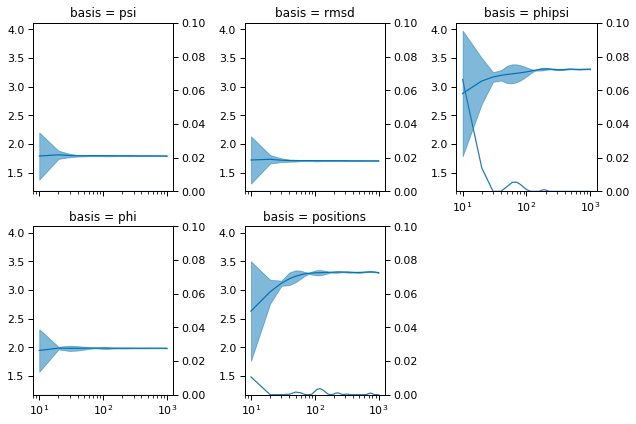

In [144]:
cols = sns.color_palette('colorblind')

mu_max = pred['f_pred'].max()
pred['ei'] = exp_imp(pred['f_pred'], sigma=pred['sd_f'], xsi=0, mu_max=mu_max)
pred.to_csv(root_dir+'predictions_with_ei.csv', index=False)


    
ei_max = np.ceil(100*pred['ei'].max()*1.1)/100
with sns.plotting_context('paper', font_scale=1.25):
    
    
    g = sns.FacetGrid(data=pred, col='basis', col_wrap=3)
    g.map_dataframe(plot_ei_rs,ylim = 0.1)
    g.set(xscale='log')
    
    
    
    

# Variable amount of data

## Import data

In [54]:
root_dir = 'outputs/mml_gp_m52/'

In [55]:
df = pd.read_csv(root_dir+'data.csv')

## Model fitting functions

In [81]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_model_1(y, X, kernel_type='rbf'):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values
        X_cols = list(X.columns)
        
        # Globals
        prop_Xu = 0.1 # proportion of observations to use as inducing variables
        l_prior = gamma(1, 0.05)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)

        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type.lower()=='rbf':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type.lower()=='exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type.lower()=='m52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type.lower()=='m32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 

        # Model
        gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Inducing variables
        num_Xu = int(X_a.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

        # Marginal likelihood
        y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
        mp = pm.find_MAP()
        
    return gp, mp, model

def get_dmatrix(df):
    if 'y' in df.columns:
        y = df.loc[:, 'y']
    else: 
        y = None
#         X = df.loc[:, df.columns.difference(['y'])]
    X_c = pt.dmatrix('~ 0 + n_s + C(basis)', data=df, return_type='dataframe')
    X_c = X_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))
    return y, X_c


## Create models with different amounts of training data

In [74]:
n_obs = [10, 25, 50]
mods = []

for n in n_obs: 
    print(n)
    tmp = df.groupby('basis').apply(lambda x: x.sample(n=n))
    y, X = get_dmatrix(tmp)
    gp, mp, model = fit_model_1(y, X, kernel_type='m52')
    mods.append({'n':n, 'gp': gp, 'mp': mp, 'model': model})

10
<class 'int'>
<class 'numpy.ndarray'>


/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecat

25
<class 'int'>
<class 'numpy.ndarray'>


/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = 319.97, ||grad|| = 0.027721: 100%|██████████| 44/44 [00:00<00:00, 111.31it/s] 


50
<class 'int'>
<class 'numpy.ndarray'>


/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = 719.18, ||grad|| = 0.039632: 100%|██████████| 69/69 [00:00<00:00, 101.74it/s]  


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/bayes_opt_gp_m52/models.p'

In [79]:
pickle.dump(obj=mods, file=open(out_dir+'models.p', 'wb'))

## Create predictions for each model

The order of the basis functions should be determined (reproducibly) by patsy (it appears to be alphabetical)

In [86]:
_, X_new_c = get_dmatrix(pred)

In [93]:
X_new = pred.loc[:, ['n', 'basis']]
X_new.head()

,n,basis
0,10.0,psi
1,20.0,psi
2,30.0,psi
3,40.0,psi
4,50.0,psi


In [94]:
all_preds = []
for mod in mods: 
    model = mod['model']
    gp = mod['gp']
    mp = mod['mp']
    n = mod['n'] # over used 'n'!
    with model: 
        # predict latent
        mu, var = gp.predict(X_new_c.values, point=mp, diag=True,pred_noise=False)
        sd_f = np.sqrt(var)
    # record results
    tmp = pd.DataFrame({'f_pred': mu, 'sd_f': sd_f})
    tmp['n_obs'] = n
    tmp = tmp.join(X_new)
    all_preds.append(tmp)

all_preds = pd.concat(all_preds)

In [95]:
all_preds.head()

,f_pred,sd_f,n_obs,n,basis
0,1.796433,0.018381,10,10.0,psi
1,1.796536,0.014087,10,20.0,psi
2,1.796589,0.011617,10,30.0,psi
3,1.796623,0.009901,10,40.0,psi
4,1.796648,0.008603,10,50.0,psi


## Expected improvement

In [104]:
all_preds['mu_max'] = all_preds.groupby('n_obs')['f_pred'].transform(lambda x: x.max())

all_preds['lb'] = all_preds['f_pred']-2*all_preds['sd_f']
all_preds['ub'] = all_preds['f_pred']+2*all_preds['sd_f']

In [120]:

# all_preds['plt_ei_max'] = all_preds.groupby('n_obs')['ei'].transform(lambda x: np.ceil(100*x.max()*1.1)/100)

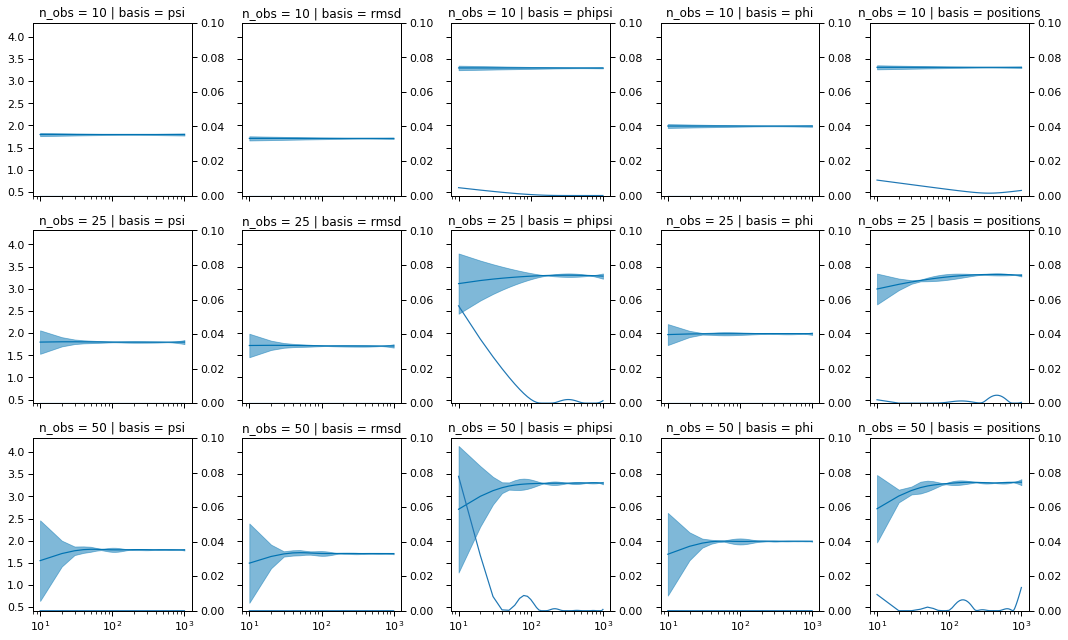

In [129]:
all_preds['ei'] = exp_imp(all_preds['f_pred'], all_preds['sd_f'], xsi=0, mu_max=all_preds['mu_max'])




with sns.plotting_context('paper', font_scale=1.25):
    g = sns.FacetGrid(data=all_preds, col='basis', row='n_obs')
    g.map_dataframe(plot_ei_rs, ylim = 0.1)
    g.set(xscale='log')

